## LSTM Network to Generate Text for Alice in Wonderland

In [1]:
import numpy
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.utils import np_utils
import sys
import matplotlib.pyplot as plt
#import string
#string.printable

Using TensorFlow backend.


In [23]:
#import os
#os.getcwd()

In [3]:
# load ascii text and convert to lowercase
#filename = "MobyDick.txt"
filename = "wonderland.txt"
raw_text = open(filename).read()
raw_text = raw_text.lower()

In [4]:
raw_text[:1000]

'alice’s adventures in wonderland\n\nlewis carroll\n\nthe millennium fulcrum edition 3.0\n\n\n\nchapter i. down the rabbit-hole\n\nalice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into the\nbook her sister was reading, but it had no pictures or conversations in\nit, ‘and what is the use of a book,’ thought alice ‘without pictures or\nconversations?’\n\nso she was considering in her own mind (as well as she could, for the\nhot day made her feel very sleepy and stupid), whether the pleasure\nof making a daisy-chain would be worth the trouble of getting up and\npicking the daisies, when suddenly a white rabbit with pink eyes ran\nclose by her.\n\nthere was nothing so very remarkable in that; nor did alice think it so\nvery much out of the way to hear the rabbit say to itself, ‘oh dear!\noh dear! i shall be late!’ (when she thought it over afterwards, it\noccurred to her that she ought to have wondered at

In [5]:
# Function for cleaning the text
import re
def clean_text(text): 
        ''' 
        Utility function to clean tweet text by removing links, 
        special characters using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    

In [6]:
raw_text = clean_text(raw_text)
raw_text[:1000]

'alice’s adventures in wonderland lewis carroll the millennium fulcrum edition 3.0 chapter i down the rabbit-hole alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it ‘and what is the use of a book, thought alice ‘without pictures or conversations?’ so she was considering in her own mind (as well as she could for the hot day made her feel very sleepy and stupid) whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her. there was nothing so very remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself ‘oh dear! oh dear i shall be late! (when she thought it over afterwards it occurred to her that she ought to have wondered at this but at the time it all seemed quite natur

In [7]:
# create a unique mapping of chars to integers as well as their reverse
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [8]:
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters:   ", n_chars)
print("Total Vocababulary: ", n_vocab)
print(chars)

Total Characters:    138936
Total Vocababulary:  46
[' ', '!', '(', ')', '*', ',', '-', '.', '0', '3', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '‘', '’', '“', '”']


In [9]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]

    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)


Total Patterns:  138836


In [10]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))

# normalise
X = X / X.max()

# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [11]:
#X = np_utils.to_categorical(X)
print(X.shape)
print(y.shape)

(138836, 100, 1)
(138836, 46)


In [12]:
print("Original y data: ")
print(dataY[1])
print("One hot encoded y data:")
print(y[1])

Original y data: 
33
One hot encoded y data:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [13]:
#X = np_utils.to_categorical(X)
#X

### Define and train the LSTM model

In [14]:
# define the LSTM model
model = Sequential()
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                11822     
Total params: 1,851,950
Trainable params: 1,851,950
Non-trainable params: 0
_________________________________________________________________


In [15]:
# define the model and checkpoint paths
model_path = "Best-Model.hdf5"
log_path = "log_training_path.log"

csv_logger = CSVLogger(log_path, separator=',', append=True)      # Log the training
checkpoint = ModelCheckpoint(model_path, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')                           # save best model
callbacks_list = [checkpoint, csv_logger]



In [17]:
# Load the model to continue the training
#model.load_weights(model_path)

In [18]:
# Train the model
model.fit(X, y, 
          epochs=100, 
          batch_size=256, 
          callbacks=callbacks_list, 
          initial_epoch=80)            # start from this epoch (continue to train a trained model)



Epoch 81/100
138836/138836 [==============================] - 294s 2ms/step - loss: 0.7677

Epoch 00081: loss improved from inf to 0.76774, saving model to Best-Model.hdf5
Epoch 82/100
138836/138836 [==============================] - 292s 2ms/step - loss: 0.7575

Epoch 00082: loss improved from 0.76774 to 0.75752, saving model to Best-Model.hdf5
Epoch 83/100
138836/138836 [==============================] - 291s 2ms/step - loss: 0.7524

Epoch 00083: loss improved from 0.75752 to 0.75241, saving model to Best-Model.hdf5
Epoch 84/100
138836/138836 [==============================] - 291s 2ms/step - loss: 0.7437

Epoch 00084: loss improved from 0.75241 to 0.74367, saving model to Best-Model.hdf5
Epoch 85/100
138836/138836 [==============================] - 291s 2ms/step - loss: 0.7368

Epoch 00085: loss improved from 0.74367 to 0.73676, saving model to Best-Model.hdf5
Epoch 86/100
138836/138836 [==============================] - 291s 2ms/step - loss: 0.7277

Epoch 00086: loss improved from 

### Plot the training error and load the best model 

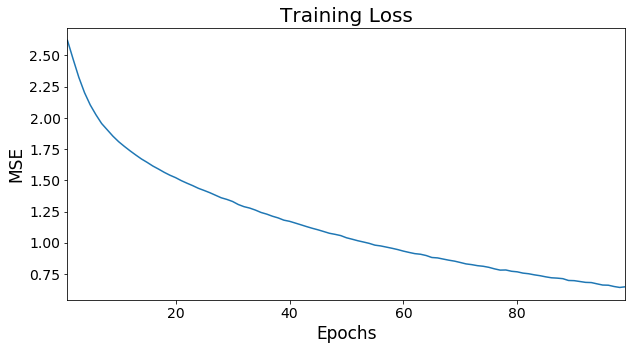

In [17]:
# Load the training history from file
log_path = "log_training_path(epoch 100).log"
log_data = pd.read_csv(log_path, sep=',', engine='python')
log_data = log_data.iloc[1:, :]

# Plot for the Error
plt.figure(figsize=(10,5))
plt.plot(log_data['loss'])
plt.title("Training Loss", fontsize=20)
plt.ylabel("MSE", fontsize=17)
plt.xlabel("Epochs", fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.autoscale(enable=True, axis="x", tight=True)
plt.show()

## Trained for 50 epochs

In [20]:
# Load the best model
model_path50 = "Best-Model(epoch 50).hdf5"
model.load_weights(model_path50)
#model.compile(loss='categorical_crossentropy', optimizer='adam')


In [21]:
# pick a random sentence to feed the model
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

Seed:
"  alice loudly ‘the idea of having the sentence first!’ ‘hold your tongue! said the queen turning pur "


In [22]:
# Generate characters
for i in range(1000):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]


 on her hands and she was suite suite frrwne it was anice and the had not the had fot its nenge ouer the had been wandering the had forgettenid large of the look and the trees all cook htok on the same as he spoke and the tabbit semling in a soeailn woice and the thought in a low to change to the sattere of the tood whet she was so the bll and said and seemed to her that she had not to the bootarsed one of the little golden key and she taid to the tatt of the table but the rat tfem ani alice was spon and semeated her on the tame as he spoke and the tabbit semling in a soeailn woice and the thought in a low to change to the sattere of the tood whet she was so the bll and said and seemed to her that she had not to the bootarsed one of the little golden key and she taid to the tatt of the table but the rat tfem ani alice was spon and semeated her on the tame as he spoke and the tabbit semling in a soeailn woice and the thought in a low to change to the sattere of the tood whet she was so 

---

After 50 epoch we can note that the model has already learned to understand how to use spaces, how to form shorter words, such as _it_, _was_, _the_, _her_. Many errors are still made though with made up words such as _bootarsed_, _semeated_, _soeailn_, nor are commas or apostrophes used. Overall however, it's impressive to see how well the LSTM network does its predictions. For being a Recurrent Neural Network (RNN) 1.8 million parameters is pretty small, but our model is already doing impressive predictions. Let's continue the training!

---

## Trained for 100 epochs

In [16]:
# Load the best model
model_path = "Best-Model(epoch 100).hdf5"
model.load_weights(model_path)
#model.compile(loss='categorical_crossentropy', optimizer='adam')


In [18]:
# pick a random sentence to feed the model
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

Seed:
" r. ‘yes! shouted alice. ‘come on then! roared the queen and alice joined the procession, wondering v "


In [19]:
# Generate characters
for i in range(1000):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]


ery much at would soop ready to say that had to sale  the katter was the first to speak foo some time without a pinute or two the caby was sneezing on the tou of hos that was good and the fardep who was penting at the more of the list of singers and was going to she went on grrwing it was a good deal of the thar cut there was nothing on it exttaering it was a good deal worse the found herself uastirgsaly ‘what are you thinking of you anl lefr i get ost a large datt of mooking all the brchess i have ordered in anything mike the mock turtle in another minute the queen’s hen and the mobk turtle interrupted ‘if you con’t explain it as you go on it’s by fir she farceeff---wale wiete was a largry good oe course i wes a different pight to be liston seem to thin you than’s all what are you’re gring to dr the too of things--they were lnok at the bnttom of the bread-- cread the made of anarpec as her sime she hot tweden spund her head and she had a venu that woieen foowes and when the had put th

---

After 100 training epochs we can see from the graph above that there's still room for some improvement. The MSE curve should eventually flatten out when the model converges, but this hasn't happened yet. However, due to hardware restrictions I won't continue training (this model was trained in the cloud for a cost). We can now see an overall improvement on the predictions. Not only the majority of the shortest words are correctly predicted, but also more complicated words such as _sneezing_, _herself_, _another_ and _ordered_ are spelled in a correct way. Also, the sentences are more plausible and makes overall more sense than before, such as: _i have ordered in anything mike_.

Several improvements can still be made though as commas are scarcely used, words are still misspelled, dashes are used three in a row etc, etc. Some suggestions to improve the results are:

- Train the model for (up to) several hundred epochs more.
- Create a deeper LSTM network (more powerful hardware should be used for this though).
- Change the batch size.
- Chose a different input length (*seq_length*) when feeding the network during training. E.g. a larger would allow the network to consider more data before each prediction, while a shorter would allow more iterations over the data set during each epoch.